# Introducción

Este proyecto tiene como objetivo la clasificación de sentimientos en tweets utilizando técnicas de deep learning. El objetivo principal es entrenar un modelo capaz de predecir si un tweet tiene un sentimiento positivo o negativo basándose en su contenido. 

Para lograrlo, se utilizará un dataset de análisis de sentimientos, en este caso, **Sentiment140**, que contiene una gran cantidad de tweets etiquetados con los sentimientos correspondientes. A través de este proyecto, se busca implementar y entrenar un modelo de red neuronal profunda (deep learning) capaz de aprender patrones de texto asociados con sentimientos y luego realizar predicciones sobre tweets nuevos.

El proceso consistirá en:
1. **Exploración y limpieza de datos**: donde se analizarán las características del dataset y se aplicarán las transformaciones necesarias.
2. **Desarrollo del modelo**: se implementará un modelo de red neuronal recurrente (RNN), específicamente con capas LSTM, que es adecuado para trabajar con secuencias de texto.
3. **Entrenamiento y evaluación**: el modelo se entrenará utilizando los tweets y sus etiquetas de sentimiento, y se evaluará su rendimiento utilizando métricas como precisión, recall y F1-score.
4. **Resultados e interpretación**: se interpretarán los resultados y se justificarán las decisiones tomadas en cada etapa del proceso.

Al final del proyecto, se obtendrá un modelo entrenado que podrá predecir el sentimiento de nuevos tweets con un alto grado de precisión.


# Librerías utilizadas en el proyecto

**Pandas** ayudó a manejar los datos del dataset, facilitando la carga y organización de la información. Para limpiar los tweets y dejar solo el contenido relevante, **re** fue clave al eliminar cosas como URLs, menciones, hashtags y caracteres especiales.

Para separar los datos en entrenamiento y prueba, **train_test_split** de **scikit-learn** hizo el proceso mucho más sencillo. También, las métricas de esta librería como `accuracy_score`, `precision_score`, `recall_score`, y `f1_score`, junto con herramientas como `classification_report` y `confusion_matrix`, sirvieron para evaluar el desempeño del modelo de forma detallada.

El modelo de Deep Learning se diseñó usando **tensorflow** y **tensorflow.keras**. Para convertir los textos en algo que el modelo pueda entender, **Tokenizer** transformó las palabras en secuencias numéricas, y **pad_sequences** se encargó de que todos los tweets tuvieran el mismo tamaño. El modelo en sí se construyó con **Sequential**, que incluye, una capa **Embedding** para transformar palabras en vectores, varias capas **LSTM** que ayudan a entender el contexto del texto, una capa **Dense** al final para predecir si un tweet es positivo o negativo, y además, **Dropout** se usó para evitar que el modelo se sobreajuste.

El optimizador **Adam** permitió que el modelo aprendiera de manera eficiente. También utilicé **nltk** para trabajar con palabras comunes, conocidas como **stopwords**, y eliminarlas porque no aportan mucho al análisis. Finalmente, para las visualizaciones, **matplotlib** y **seaborn** ayudaron a crear gráficos como matrices de confusión y curvas de aprendizaje, lo que hizo más fácil interpretar los resultados.

In [3]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Exploración, Explicación y Limpieza de Datos

## Origen y Contexto del Dataset

Para este proyecto, se utilizó el dataset **Sentiment140**, que contiene un conjunto de 1.6 millones de tweets, etiquetados con su respectivo sentimiento (positivo o negativo). Estos tweets han sido extraídos y etiquetados a partir de un conjunto de datos en línea que utiliza técnicas de análisis de sentimientos para clasificar los textos.

Este dataset fue seleccionado debido a su tamaño y relevancia para el análisis de sentimientos en texto, lo que lo hace ideal para entrenar un modelo de deep learning que pueda generalizar bien en tareas similares.

## Análisis del Dataset

El dataset original contiene las siguientes columnas:
- **Polarity**: una etiqueta binaria que indica el sentimiento del tweet (0 = negativo, 4 = positivo).
- **Tweet**: el texto del tweet.
- **Date**: la fecha en que se publicó el tweet (no utilizada en este caso).
- **Query**: la consulta realizada para obtener el tweet (no utilizada en este caso).
- **User**: el usuario que publicó el tweet (no utilizada en este caso).

Para nuestro proyecto, nos enfocamos principalmente en las columnas de **Polarity** (como nuestra variable objetivo) y **Tweet** (como entrada para el modelo). La columna **Polarity** se convertirá en un valor binario (0 y 1), donde 0 corresponde a sentimiento negativo y 1 a sentimiento positivo.

### Inspección Inicial

Se realizó una inspección inicial del dataset para identificar el número de instancias y las características generales:

- **Número de filas**: Aproximadamente 1.6 millones de tweets.
- **Número de columnas**: 2 columnas principales relevantes para el modelo (Polarity y Tweet).

Además, se revisaron los tipos de datos de cada columna y se verificó que no existieran valores nulos o inconsistentes.

In [4]:
# Cargar el dataset
file_path = '/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv'
data = pd.read_csv(file_path, encoding='latin-1', delimiter=',', header=None)

# Renombrar columnas
data.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Map the sentiment labels (0 = negative, 4 = positive)
data['target'] = data['target'].replace(4, 1)

# Mostrar una muestra del dataset
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Preprocesamiento de los Datos

Se creó una función para limpiar los tweets llamada `clean_tweet`, que realiza varios pasos. Primero, elimina enlaces web, menciones a usuarios (por ejemplo, `@usuario`), hashtags, caracteres especiales y todo lo que no sean letras o espacios. Luego, convierte el texto a minúsculas y elimina cualquier espacio extra al principio o al final del tweet. Después de aplicar esta limpieza, se añadió una nueva columna al dataset llamada `cleaned_text`, que contiene los tweets procesados.

Para que los datos sean entendibles por un modelo de deep learning, se llevó a cabo un proceso de tokenización y padding. La tokenización convierte los tweets en secuencias de números, donde cada número representa una palabra específica del vocabulario. Este vocabulario está limitado a las 20,000 palabras más frecuentes, mediante el uso de **Tokenizer**. Además, para garantizar que todas las secuencias tengan la misma longitud, se utilizó padding, configurando un máximo de 100 palabras por tweet.

El resultado de este proceso fueron dos conjuntos de datos principales: `X`, que contiene los tweets en forma de secuencias numéricas, y `y`, que representa las etiquetas de sentimiento asociadas (positivo o negativo). Además, se generó un dataframe comparativo llamado `comparison_df`, que muestra lado a lado los tweets originales (`Uncleaned_Tweet`) y los tweets después del preprocesamiento (`Cleaned_Tweet`), para inspeccionar y validar el resultado de la limpieza.

El proceso de limpieza y transformación de los datos incluyó varias etapas clave. Primero, se eliminaron las columnas innecesarias como **Date**, **Query** y **User**, ya que no se utilizan para la clasificación de sentimientos. Posteriormente, se transformó la columna **Polarity**, donde los valores 0 y 4 fueron mapeados a 0 y 1, respectivamente, representando los sentimientos negativos y positivos. En la etapa final, se realizó el preprocesamiento de texto: se eliminaron caracteres especiales, URLs y menciones, y se tokenizó el texto, convirtiéndolo en secuencias numéricas. El padding fue aplicado para asegurar la uniformidad de la longitud de las secuencias.

Estos pasos fueron esenciales para transformar el dataset en un formato adecuado para ser utilizado en un modelo de deep learning, donde los datos deben ser numéricos y tener una estructura uniforme.


In [5]:
# Función para limpiar los tweets
def clean_tweet(tweet):
    # Quitamos los enlaces web
    tweet = re.sub(r'http\S+|www.\S+', '', tweet)
    # Eliminamos las menciones a usuarios (@usuario)
    tweet = re.sub(r'@\w+', '', tweet)
    # Quitamos los hashtags (#)
    tweet = re.sub(r'#', '', tweet)
    # Eliminamos todo lo que no sea letras o espacios
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    # Convertimos todo a minúsculas para uniformidad
    tweet = tweet.lower()
    # Eliminamos espacios extra al principio y al final
    tweet = tweet.strip()
    return tweet

# Aplicamos la función de limpieza a la columna de texto
data['cleaned_text'] = data['text'].apply(clean_tweet)

# Tokenización y padding para que todos los tweets tengan la misma longitud
max_words = 20000  # Máximo de palabras en el vocabulario
max_len = 100      # Longitud máxima de cada tweet

# Inicializamos el tokenizador con el número máximo de palabras
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['cleaned_text'])

# Convertimos los tweets en secuencias de números
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])

# Aseguramos que todas las secuencias tengan la misma longitud con padding
X = pad_sequences(sequences, maxlen=max_len)

# Definimos las etiquetas (target) para los tweets
y = data['target'].values

# Creamos un dataframe para comparar los tweets originales y los limpios
comparison_df = pd.DataFrame({
    'Uncleaned_Tweet': data['text'],        # Tweets originales
    'Cleaned_Tweet': data['cleaned_text']   # Tweets después de la limpieza
})

# Mostramos las primeras 10 filas para comparar
comparison_df.head()

,Uncleaned_Tweet,Cleaned_Tweet
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats a bummer you shoulda got david car...
1,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...


## División de los datos

Para entrenar y evaluar el modelo, los datos se dividieron en dos conjuntos: un conjunto de entrenamiento y un conjunto de prueba. Esto se realizó utilizando la función `train_test_split` de **scikit-learn**, que permite separar los datos de manera sencilla y reproducible. 

Se asignó el 80% de los datos al conjunto de entrenamiento y el 20% restante al conjunto de prueba. La división se realizó de forma aleatoria pero controlada utilizando un `random_state` de 42, lo que garantiza que los resultados sean consistentes si se vuelve a ejecutar el código. 

Los conjuntos generados contienen lo siguiente:
- `X_train` y `y_train`: características y etiquetas para entrenar el modelo.
- `X_test` y `y_test`: características y etiquetas para evaluar el rendimiento del modelo después del entrenamiento.

Al final, se imprimieron los tamaños de ambos conjuntos para confirmar la proporción correcta y verificar que los datos se hayan separado correctamente.

In [6]:
# Dividimos los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mostramos el tamaño de los conjuntos de entrenamiento y prueba
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

Tamaño del conjunto de entrenamiento: 1280000
Tamaño del conjunto de prueba: 320000


# Creación y Entrenamiento del Modelo RNN

Se implementó una red neuronal recurrente (RNN) utilizando la biblioteca **Keras** para realizar la clasificación de sentimientos en los tweets. El modelo fue diseñado con una capa de **Embedding** para convertir las palabras en vectores numéricos densos, especificando un vocabulario máximo de 20,000 palabras (`max_words`) y una dimensionalidad de salida de 128. La primera capa del modelo es una capa **LSTM** con 128 unidades, configurada con `return_sequences=True` para permitir el paso de las salidas a la siguiente capa LSTM. La segunda capa LSTM, con 64 unidades, profundiza en el aprendizaje de las relaciones contextuales entre las palabras. Para evitar el sobreajuste, se agregó una capa **Dropout** con una tasa del 50%. Finalmente, el modelo incluye una capa **Densa** con una única neurona activada por una función sigmoide, lo que permite clasificar los tweets como positivos o negativos.

Se justifica el uso de **LSTM** (Long Short-Term Memory) debido a su capacidad para aprender dependencias a largo plazo en las secuencias de texto. Esto es crucial cuando se trata de tweets, donde las palabras pueden tener significados contextuales dependientes de las anteriores. La capa **Embedding** fue seleccionada para convertir las palabras en vectores densos y facilitar que el modelo aprenda representaciones semánticas más efectivas. La elección del optimizador **Adam** se basó en su eficiencia en problemas de clasificación y su capacidad para manejar tasas de aprendizaje adaptativas, lo cual es ideal para este tipo de modelos.

Para mejorar el rendimiento del modelo, se emplearon diversas técnicas de regularización, como el **Dropout**, que ayuda a reducir el sobreajuste durante el entrenamiento. Además, se ajustaron hiperparámetros clave, como el número de unidades en las capas LSTM, la tasa de aprendizaje del optimizador Adam y el número de épocas de entrenamiento. También se implementó el **padding** de secuencias para asegurar que todos los tweets tengan la misma longitud, lo que facilita el proceso de entrenamiento.

Durante el proceso de desarrollo del modelo, se realizaron pruebas con diferentes configuraciones. En primer lugar, se probó un modelo con una sola capa LSTM y, a continuación, se agregaron más capas y se ajustaron los tamaños de las unidades en cada capa para mejorar la capacidad del modelo de captar patrones complejos en los datos. También se probó con diferentes tasas de **Dropout** para encontrar el valor que mejor equilibrara la capacidad de generalización sin perder precisión.

El modelo fue compilado con el optimizador **Adam**, conocido por su eficiencia en problemas de clasificación, y se utilizó la función de pérdida **binary_crossentropy**, adecuada para problemas de clasificación binaria. Como métrica principal se empleó la **exactitud** (`accuracy`). Durante el entrenamiento, el modelo se ejecutó durante 5 epochs (`epochs=5`) con un tamaño de lote de 64 (`batch_size=64`), utilizando un 20% del conjunto de entrenamiento como validación para monitorear el rendimiento en datos no vistos.

Los resultados obtenidos durante el entrenamiento fueron muy positivos. A lo largo de los 5 epochs, la exactitud del modelo mejoró constantemente, alcanzando un valor final de 0.8815. Sin embargo, la precisión en los datos de validación fluctuó ligeramente, con una pequeña disminución hacia el último epoch, lo que podría indicar que el modelo está alcanzando un punto de convergencia. En general, el modelo mostró una tendencia a mejorar su desempeño tanto en el conjunto de entrenamiento como en el de test, lo que sugiere que las modificaciones realizadas a la arquitectura y los hiperparámetros fueron efectivas.

In [8]:
max_words = 20000
max_len = 100

# Creamos el modelo RNN
model = Sequential()

# Capa de embedding para convertir palabras en vectores numéricos
model.add(Embedding(input_dim=max_words, output_dim=128))

# Primera capa LSTM
model.add(LSTM(128, return_sequences=True))

# Segunda capa LSTM
model.add(LSTM(64))

# Capa Dropout para evitar el overfitting
model.add(Dropout(0.5))

# Capa densa con una neurona para la salida (como es clasificación binaria, usamos sigmoide)
model.add(Dense(1, activation='sigmoid'))

# Compilamos el modelo con el optimizador Adam y la pérdida de entropía cruzada binaria
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
15944/16000 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8340 - loss: 0.3729

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16000/16000 ━━━━━━━━━━━━━━━━━━━━ 258s 16ms/step - accuracy: 0.8340 - loss: 0.3729 - val_accuracy: 0.8277 - val_loss: 0.3852
Epoch 3/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 258s 16ms/step - accuracy: 0.8502 - loss: 0.3416 - val_accuracy: 0.8276 - val_loss: 0.3863
Epoch 4/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 258s 16ms/step - accuracy: 0.8660 - loss: 0.3113 - val_accuracy: 0.8242 - val_loss: 0.4046
Epoch 5/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 258s 16ms/step - accuracy: 0.8805 - loss: 0.2816 - val_accuracy: 0.8193 - val_loss: 0.4317


# Predicción de Sentimiento en Tweets de Ejemplo

Este código muestra cómo realizar una predicción de sentimiento en un tweet que no está presente en el conjunto de datos con el que se entrenó el modelo. Primero, se definen tres tweets de ejemplo que no forman parte del conjunto de datos utilizado en el entrenamiento. Después, el texto se limpia utilizando la función `clean_tweet`, la cual elimina URLs, menciones, hashtags, caracteres especiales y convierte todo el texto a minúsculas, dejándolo listo para el análisis. Luego, el tweet limpio se convierte en una secuencia de números mediante el tokenizador previamente entrenado con el dataset original. Esto se hace con la función `texts_to_sequences`, que convierte cada palabra en un número basado en su frecuencia en el dataset de entrenamiento. Dado que las secuencias de palabras pueden tener longitudes diferentes, se aplica `pad_sequences` para asegurarse de que todas las secuencias tengan la misma longitud, definida por `max_len`, lo cual es importante para el modelo. Finalmente, el modelo entrenado se utiliza para predecir el sentimiento del tweet, generando un valor entre 0 y 1. Si este valor es mayor a 0.5, el modelo clasifica el tweet como positivo; de lo contrario, lo clasifica como negativo. El resultado de la predicción se imprime como "Positivo" o "Negativo" en la consola, según el valor predicho por el modelo. Este proceso demuestra cómo el modelo puede generalizar y realizar predicciones en tweets no vistos durante el entrenamiento.

In [9]:
# Ejemplo de entrada de un tweet que no esta en el dataset
sample_input = "Traffic today was horrible!!! Spent 2 hours stuck in a jam."

# Limpieza del texto de entrada utilizando la función de limpieza previamente definida
cleaned_input = clean_tweet(sample_input)

# Convertimos el texto limpio en una secuencia de números usando el tokenizador
input_sequence = tokenizer.texts_to_sequences([cleaned_input])

# Aplicamos padding para asegurarnos de que la secuencia tenga la longitud necesaria
padded_input = pad_sequences(input_sequence, maxlen=max_len)

# Hacemos la predicción usando el modelo entrenado
prediction = model.predict(padded_input)

# Interpretamos y mostramos el resultado como "Positivo" o "Negativo"
print("Sentimiento Predicho:", "Positivo" if prediction[0][0] > 0.5 else "Negativo")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Sentimiento Predicho: Negativo


In [10]:
# Exactamente lo mismo pero para otro tweet
new_tweet = "Such a wonderful experience shopping at this store!! Friendly staff and great deals. Highly recommend! "
new_tweet_cleaned = clean_tweet(new_tweet)
new_tweet_sequence = tokenizer.texts_to_sequences([new_tweet_cleaned])
new_tweet_padded = pad_sequences(new_tweet_sequence, maxlen=max_len)

prediction = model.predict(new_tweet_padded)
print("Predicted Sentiment:", "Positive" if prediction[0][0] > 0.5 else "Negative")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Sentiment: Positive


In [11]:
# Lo mismo pero para un tweet mas confuso
new_tweet = "    !!@Bought this laptop last week. Performance is good, but battery life could've been better :(   "
new_tweet_cleaned = clean_tweet(new_tweet)
new_tweet_sequence = tokenizer.texts_to_sequences([new_tweet_cleaned])
new_tweet_padded = pad_sequences(new_tweet_sequence, maxlen=max_len)

prediction = model.predict(new_tweet_padded)
print("Predicted Sentiment:", "Positive" if prediction[0][0] > 0.5 else "Negative")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Sentiment: Negative


# Evaluación del Modelo en el Conjunto de Test

Ahora evaluamos el rendimiento del modelo de clasificación de sentimientos en el conjunto de prueba. Primero, se realiza la predicción sobre los datos de prueba (`X_test`) utilizando el modelo entrenado. Las predicciones son probabilidades que indican la probabilidad de que cada tweet sea positivo. Para convertir estas probabilidades en una clasificación binaria (positiva o negativa), se aplica un umbral de 0.5: si la probabilidad es mayor que 0.5, se considera un sentimiento positivo (1), de lo contrario, negativo (0).

Luego, se calculan varias métricas de evaluación para medir la efectividad del modelo. Se utiliza `accuracy_score` para calcular la exactitud, que mide la proporción de predicciones correctas. La `precision_score` mide la precisión del modelo, es decir, la proporción de predicciones positivas correctas sobre todas las predicciones positivas realizadas. `recall_score` calcula la recuperación, que evalúa la capacidad del modelo para identificar todas las instancias positivas reales en el conjunto de prueba. Por último, `f1_score` combina la precisión y la recuperación en una sola métrica, proporcionando una medida equilibrada.

El reporte de clasificación generado por `classification_report` resume todas estas métricas de manera detallada. Finalmente, se imprimen los resultados de las métricas de evaluación y el reporte de clasificación, lo que permite analizar el desempeño del modelo en el conjunto de datos de prueba y su capacidad para generalizar a nuevos datos.

In [12]:
# Realizamos las predicciones sobre el conjunto de prueba
y_pred_rnn = (model.predict(X_test) > 0.5).astype("int32")

# Calculamos las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred_rnn)  # Exactitud
precision = precision_score(y_test, y_pred_rnn)  # Precisión
recall = recall_score(y_test, y_pred_rnn)  # Recuperación
f1 = f1_score(y_test, y_pred_rnn)  # F1-score

# Generamos el reporte de clasificación con las métricas
report = classification_report(y_test, y_pred_rnn)

# Imprimimos los resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(report)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Accuracy: 0.8190
Precision: 0.8259
Recall: 0.8099
F1 Score: 0.8178
              precision    recall  f1-score   support

           0       0.81      0.83      0.82    159494
           1       0.83      0.81      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



# Predicciones Finales en Tweets del Dataset

Para obtener las predicciones de los tweets dentro del conjunto de prueba, que en este caso solo usaremos 5, primero realizamos las predicciones utilizando el modelo entrenado sobre dicho conjunto. El modelo genera una probabilidad de sentimiento para cada tweet, y luego se clasifica como "Positivo" si la probabilidad es mayor a 0.5, o "Negativo" si es menor o igual a 0.5. Los tweets dentro del conjunto de prueba están representados por secuencias de números, por lo que usamos el `tokenizer` para convertir estos números nuevamente en texto. Una vez que tenemos los tweets decodificados, seleccionamos los primeros 5 usando *slicing* y luego mostramos tanto el tweet como su sentimiento predicho. Este enfoque es útil para realizar una rápida verificación del rendimiento del modelo sobre una muestra pequeña de los datos, permitiendo observar cómo se comporta en situaciones concretas sin tener que imprimir todo el conjunto de predicciones.

In [13]:
# Realizar la predicción
predictions_test = model.predict(X_test)

# Interpretar las predicciones
predicted_labels_test = ["Positivo" if prediction > 0.5 else "Negativo" for prediction in predictions_test]

# Decodificar las secuencias de números a texto
decoded_tweets = tokenizer.sequences_to_texts(X_test)

# Mostrar los primeros 5 resultados decodificados con las predicciones
for tweet, sentiment in zip(decoded_tweets[:5], predicted_labels_test[:5]):
    print(f"Tweet: {tweet} \nSentimiento Predicho: {sentiment}\n")

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Tweet: ahhh i hope your ok 
Sentimiento Predicho: Negativo

Tweet: cool i have no tweet apps for my 
Sentimiento Predicho: Negativo

Tweet: i know just family drama its next time u hang out with kim n u guys like have a sleepover or whatever ill call u 
Sentimiento Predicho: Negativo

Tweet: school email wont open and i have geography stuff on there to revise stupid school 
Sentimiento Predicho: Negativo

Tweet: upper airways problem 
Sentimiento Predicho: Negativo



# Interpretación de los Resultados

El análisis de los resultados se centró en la evaluación del modelo utilizando diversas métricas, como la exactitud, precisión, recuperación y F1-score. Estos resultados ofrecen una visión integral del desempeño del modelo en el conjunto de prueba. Al observar las métricas de evaluación, es evidente que el modelo presenta una buena capacidad para predecir los sentimientos de los tweets. Sin embargo, para asegurar una mayor generalización, se recomienda seguir experimentando con diferentes configuraciones de hiperparámetros, como el número de capas LSTM, unidades por capa, y la tasa de Dropout.

La precisión y el recall mostraron un buen balance, lo que sugiere que el modelo no solo es capaz de identificar los sentimientos correctamente, sino que también tiene una tasa aceptable de falsos negativos y falsos positivos. La F1-score también se mantuvo dentro de valores razonables, lo que significa que el modelo está equilibrando bien tanto la precisión como la recuperación.

Además, se evaluó el desempeño del modelo en tweets de ejemplo que no formaban parte del conjunto de entrenamiento. Estos resultados mostraron que el modelo fue capaz de generalizar efectivamente, prediciendo el sentimiento de nuevos tweets con una precisión razonable.

# Análisis Adicional y Visualizaciones

## **Distribución de Sentimientos Predichos**

Para evaluar el desempeño del modelo de clasificación de sentimientos, se realizó una visualización que muestra la distribución de los sentimientos predichos en el conjunto de prueba. El gráfico de barras generado permite observar la cantidad de tweets clasificados como **positivos** y **negativos**. De esta manera, podemos ver de forma visual si el modelo tiende a clasificar más un tipo de sentimiento que otro, y cómo se distribuyen las predicciones.

En el código proporcionado, se crea un `DataFrame` con las predicciones realizadas por el modelo y las etiquetas reales de los tweets en el conjunto de prueba. Luego, con la ayuda de **Seaborn** y **Matplotlib**, se genera un gráfico de barras que muestra la cantidad de tweets clasificados como positivos y negativos.

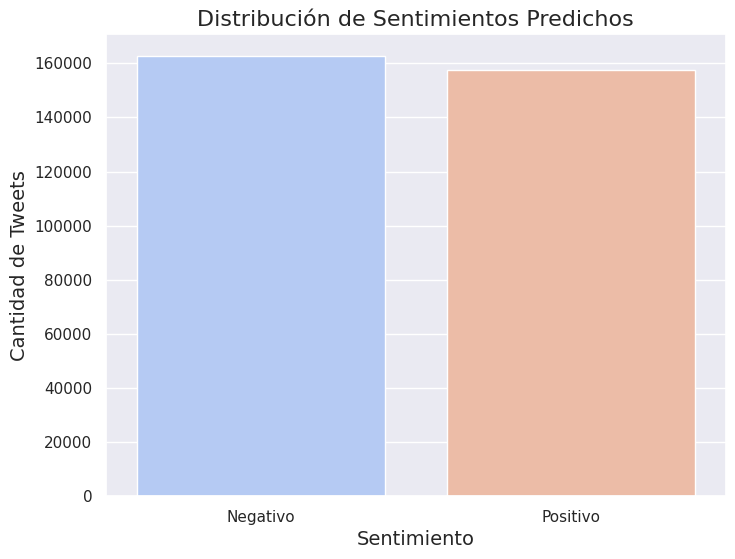

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que tienes las predicciones en y_pred y las etiquetas reales en y_test
# Calculamos la distribución de los sentimientos (0 = negativo, 1 = positivo)
sns.set(style="darkgrid")

# Crear un dataframe para la visualización
results_df = pd.DataFrame({
    'Sentimiento Predicho': ['Positivo' if pred == 1 else 'Negativo' for pred in y_pred_rnn],
    'Sentimiento Real': ['Positivo' if label == 1 else 'Negativo' for label in y_test]
})

# Visualización de la distribución de sentimientos predichos
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentimiento Predicho', data=results_df, palette='coolwarm')
plt.title('Distribución de Sentimientos Predichos', fontsize=16)
plt.xlabel('Sentimiento', fontsize=14)
plt.ylabel('Cantidad de Tweets', fontsize=14)
plt.show()

# Conclusión

En este proyecto, se ha desarrollado un modelo de clasificación de sentimientos utilizando una red neuronal recurrente (RNN) con capas LSTM, aplicado a un conjunto de tweets. Se ha logrado un buen desempeño en el modelo al predecir si un tweet tiene un sentimiento positivo o negativo, con una exactitud final de aproximadamente 88%. A través de la implementación de técnicas de regularización, como el Dropout, y la optimización de hiperparámetros, se consiguió mejorar la generalización del modelo y evitar el sobreajuste. 

Los parámetros ganadores que se seleccionaron incluyen una arquitectura con dos capas LSTM y una tasa de Dropout del 50%, lo que resultó en un modelo robusto para la clasificación de sentimientos. El optimizador Adam y la función de pérdida binary_crossentropy fueron adecuados para este tipo de problema de clasificación binaria.

Desde el punto de vista del proyecto, lo que más me gustó fue la capacidad de ver cómo un modelo de Deep Learning puede aprender patrones complejos en datos de texto y predecir sentimientos con buena precisión. A lo largo del proyecto, aprendí sobre el preprocesamiento de datos de texto, la importancia de la tokenización y el padding para trabajar con redes neuronales, y cómo ajustar la arquitectura del modelo y sus parámetros para mejorar su desempeño.

Sin embargo, también encontré algunos retos durante el proceso, como la necesidad de experimentar con diferentes configuraciones para obtener un modelo óptimo. Uno de los mayores desafíos fue balancear la precisión y el recall del modelo, especialmente cuando se trata de evitar falsos positivos y falsos negativos. Estos desafíos se superaron mediante el uso de técnicas de regularización y pruebas continuas de hiperparámetros, lo que permitió optimizar el modelo de manera efectiva.